In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import liana as li
from liana.method._pipe_utils._common import _get_props
from liana.method.sp._utils import _add_complexes_to_var
from liana._logging import _logg
from liana.method._pipe_utils import prep_check_adata, assert_covered
from scipy.sparse import csr_matrix

# note squidpy is needed for autocorrelation / svgs
import squidpy as sq

/home/pschaefer/miniforge3/envs/liana_env/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
/home/pschaefer/miniforge3/envs/liana_env/lib/python3.11/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/home/pschaefer/miniforge3/envs/liana_env/lib/python3.11/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.


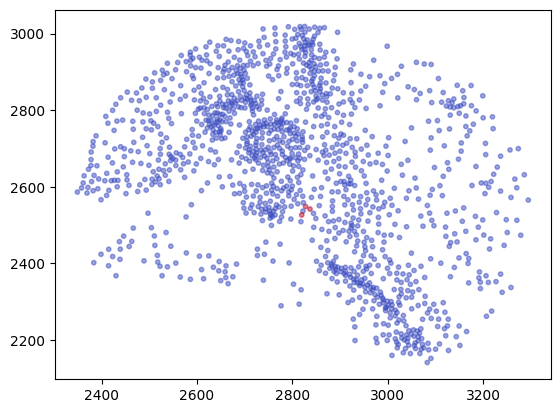

In [2]:
adata = sc.read_h5ad("/home/pschaefer/sds-hd/sd22b002/projects/hitchhikers_guide_to_spatial_project/data/MS_xenium_data_v5_with_images_tmap.h5ad")

annotation_col = "celltype"
library_key = "sample_id"  # (could also be fov)
min_transcripts_per_cell = 20
min_cells_per_transcript = 1_0000

source_labels_to_plot = [
    "Myeloid",
    "Vasc_Myeloid",
    "Endothelial",
    "Vascular",
    "T_cell",
]

# subset to a single sample for now (median of 130 counts)
adata = adata[adata.obs["sample_id"] == "MSa1", :].copy()

# create better cell type categories
mapping_dict = {
    "MP/MiGl_1": "Myeloid",
    "MP/MiGl_2": "Myeloid",
    "vascular_MP_1": "Vasc_Myeloid",
    "vascular_MP_2": "Vasc_Myeloid",
    "vascular_MP_3": "Vasc_Myeloid",
    "Vascular_1": "Vascular",
    "Vascular_2": "Vascular",
    "Astro_WM": "Astrocyte",
    "Astro_GM": "Astrocyte",
    "Astro_WM_DA": "Astrocyte",
    "Astro_GM_DA": "Astrocyte",
    "OLG_WM": "Oligo",
    "OLG_WM_DA": "Oligo",
    "OLG_GM": "Oligo",
    "OPC": "OPC",
    "OPC_DA": "OPC",
    "COP": "COP",
    "NFOL/MFOL": "NFOL",
    "Schw": "Schwann",
    "Endo": "Endothelial",
    "Neurons": "Neurons",
    "vascular_T-cell": "T_cell",
    "T-cell": "T_cell",
    "Ependymal": "Ependymal",
    "unknown": "unknown",
}
adata.obs["celltype"] = pd.Categorical(adata.obs["Level2"].map(mapping_dict))
adata = adata[adata.obs["celltype"] != "unknown", :].copy()

# liana assumes that adata.var.index has no name!
adata.var.index.name = None

# qc stats
adata.obs["total_transcripts"] = adata.X.sum(axis=1).A1
adata.var["total_cells"] = (adata.X > 0).sum(axis=0).A1

adata = adata[adata.obs["total_transcripts"] >= min_transcripts_per_cell, :].copy()
adata = adata[:, adata.var["total_cells"] >= min_cells_per_transcript].copy()

adata.layers["counts"] = adata.X.copy()

# scale to median total counts and log1p transform
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

# sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.tl.pca(adata)

#li.ut.spatial_neighbors(adata=adata, bandwidth=100)

sq.gr.spatial_neighbors(
    adata,
    spatial_key="spatial",
    library_key=library_key,
    coord_type="generic",
    percentile=50,
    delaunay=True,
    key_added="juxtaview",
)

from scipy.spatial.distance import cdist

weight_idx = 400
dists = cdist(adata.obsm["spatial"][[weight_idx], :], adata.obsm["spatial"]).flatten()
close_dists = dists < np.quantile(dists, 0.01)

max_idx = 1_000_000
weight_idx = 400
plt.scatter(
    x=adata.obsm["spatial"][close_dists, 0],
    y=adata.obsm["spatial"][close_dists, 1],
    s=10.0,
    c=adata.obsp["juxtaview_connectivities"][weight_idx, close_dists].toarray().flatten(),
    cmap="coolwarm",
    alpha=0.5,
)
plt.show()

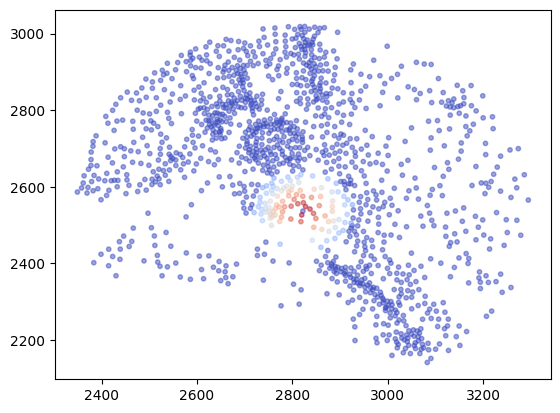

In [26]:
li.ut.spatial_neighbors(adata=adata, bandwidth=60, key_added="paraview")

from scipy.spatial.distance import cdist

weight_idx = 400
dists = cdist(adata.obsm["spatial"][[weight_idx], :], adata.obsm["spatial"]).flatten()
close_dists = dists < np.quantile(dists, 0.01)

max_idx = 1_000_000
weight_idx = 400
plt.scatter(
    x=adata.obsm["spatial"][close_dists, 0],
    y=adata.obsm["spatial"][close_dists, 1],
    s=10.0,
    c=adata.obsp["paraview_connectivities"][weight_idx, close_dists].toarray().flatten(),
    cmap="coolwarm",
    alpha=0.5,
)
plt.show()

In [9]:
#from spatialdata_io import cosmx
#
#sdata = cosmx("/home/pschaefer/sds-hd/sd22b002/projects/hitchhikers_guide_to_spatial_project/data/Pancreas-CosMx-WTx")

In [67]:
import os
from spatialdata_io import xenium
import spatialdata as sd

# Define paths
data_path = "/home/pschaefer/sds-hd/sd22b002/projects/hitchhikers_guide_to_spatial_project/data/Xenium_Prime_Human_Ovary_FF_outs"
sdata_path = "/home/pschaefer/sds-hd/sd22b002/projects/hitchhikers_guide_to_spatial_project/data/Xenium_Prime_Human_Ovary_FF_outs/sdata.zarr"

# Check if zarr store exists
if os.path.exists(sdata_path):
    print("Loading existing zarr store...")
    sdata = sd.read_zarr(sdata_path)
else:
    print("Zarr store not found. Reading data using xenium function...")
    sdata = xenium(data_path,
                   morphology_focus=False,  # we don't need the morphology images here
                   transcripts=False,       # we don't need individual transcripts here
                   cells_as_circles=False,  # default argument in next release
                   )
    print("Writing data to zarr store...")
    sdata.write(sdata_path)

print("Data loaded successfully!")
sdata

Loading existing zarr store...


/home/pschaefer/miniforge3/envs/liana_env/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'


Data loaded successfully!


SpatialData object, with associated Zarr store: /home/pschaefer/sds-hd/sd22b002/projects/hitchhikers_guide_to_spatial_project/data/Xenium_Prime_Human_Ovary_FF_outs/sdata.zarr
├── Labels
│     ├── 'cell_labels': DataTree[yx] (101928, 54013), (50964, 27006), (25482, 13503), (12741, 6751), (6370, 3375)
│     └── 'nucleus_labels': DataTree[yx] (101928, 54013), (50964, 27006), (25482, 13503), (12741, 6751), (6370, 3375)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (1157659, 1) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (1111031, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (1157659, 5001)
with coordinate systems:
    ▸ 'global', with elements:
        cell_labels (Labels), nucleus_labels (Labels), cell_boundaries (Shapes), nucleus_boundaries (Shapes)

In [ ]:
min_transcripts_per_cell  = 50
min_cells_per_transcript = 500

adata_sd = sdata.tables["table"].copy()

# qc stats
adata_sd.obs["total_transcripts"] = adata_sd.X.sum(axis=1).A1
adata_sd.var["total_cells"] = (adata_sd.X > 0).sum(axis=0).A1

adata_sd = adata_sd[adata_sd.obs["total_transcripts"] >= min_transcripts_per_cell, :].copy()
adata_sd = adata_sd[:, adata_sd.var["total_cells"] >= min_cells_per_transcript].copy()

adata_sd.layers["counts"] = adata_sd.X.copy()

# scale to median total counts and log1p transform
sc.pp.normalize_total(adata_sd)
sc.pp.log1p(adata_sd)

sc.pp.highly_variable_genes(adata_sd, n_top_genes=2000)
sc.tl.pca(adata_sd)

# get spatial graph
li.ut.spatial_neighbors(adata=adata_sd, bandwidth=100, key_added="paraview")

adata_sd

AnnData object with n_obs × n_vars = 1144582 × 4846
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'total_transcripts'
    var: 'gene_ids', 'feature_types', 'genome', 'total_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatialdata_attrs', 'log1p', 'hvg', 'pca'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'
    layers: 'counts'

/home/pschaefer/miniforge3/envs/liana_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1776: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/pschaefer/miniforge3/envs/liana_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1776: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


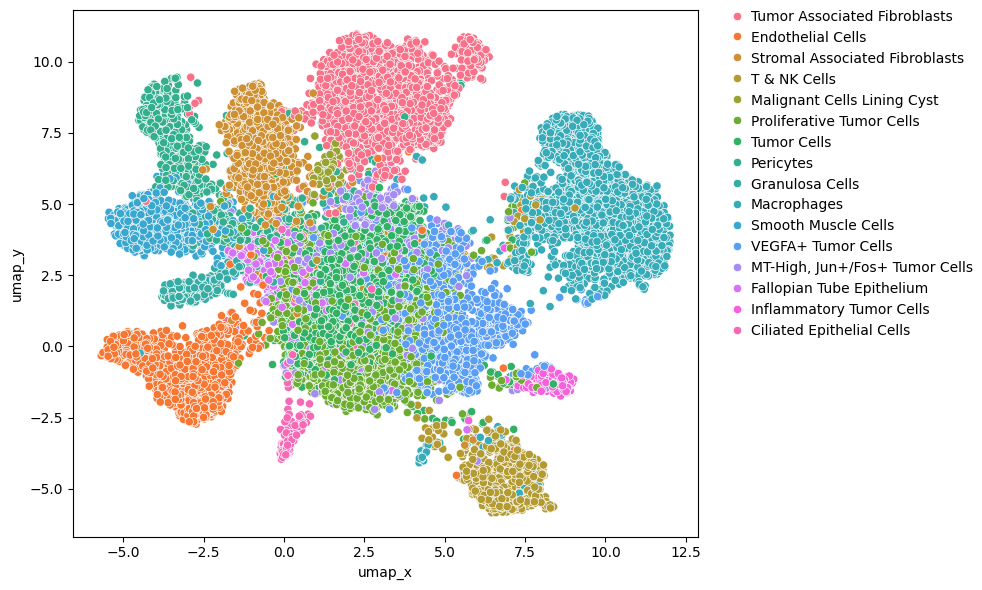

In [69]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

obs = pd.read_csv("/home/pschaefer/sds-hd/sd22b002/projects/hitchhikers_guide_to_spatial_project/data/ovariance_cancer_ffpe_dissociated/FLEX_Ovarian_Barcode_Cluster_Annotation.csv")

adata = sc.read_10x_h5("/home/pschaefer/sds-hd/sd22b002/projects/hitchhikers_guide_to_spatial_project/data/ovariance_cancer_ffpe_dissociated/17k_Ovarian_Cancer_scFFPE_count_filtered_feature_bc_matrix.h5")
adata.var_names_make_unique()
adata.obs = adata.obs.join(obs.set_index("Barcode"))
adata = adata[~pd.isna(adata.obs["Cell Annotation"]), :].copy()

adata.obs["total_counts"] = adata.X.sum(axis=1).A1
adata.var["total_cells"] = (adata.X > 0).sum(axis=0).A1
adata.obs["sample"] = "sample" # for pbulk

adata = adata[adata.obs["total_counts"] >= 100, :].copy()
adata = adata[:, adata.var["total_cells"] >= 20].copy()

adata.layers["counts"] = adata.X.copy()

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.tl.pca(adata)

sc.pp.neighbors(adata)
sc.tl.umap(adata, key_added="X_umap_subset")

adata.obs["umap_x"] = adata.obsm["X_umap_subset"][:, 0]
adata.obs["umap_y"] = adata.obsm["X_umap_subset"][:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(adata.obs, x="umap_x", y="umap_y", hue="Cell Annotation")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()

In [ ]:
import decoupler as dc

pdata = dc.pp.pseudobulk(
    adata=adata,
    layer="counts",
    groups_col="Cell Annotation",
    sample_col="sample",
    mode="sum",
)
sc.pp.normalize_total(pdata)
sc.pp.log1p(pdata)
sc.pp.scale(pdata)

net = pd.DataFrame(pdata.X)
net.index = pdata.obs["Cell Annotation"].to_list()
net.columns = pdata.var.index.to_list()
net = net.reset_index(names="celltype")
net = net.melt(id_vars="celltype")
net = net.rename(columns={"celltype": "source", "variable": "target", "value": "weight"})

# transfer labels to our xenium data
dc.mt.ulm(data=adata_sd, net=net, verbose=True)
adata_sd.obs["celltype"] = adata_sd.obsm["score_ulm"].columns[np.argmax(adata_sd.obsm["score_ulm"].values, axis=1)]

,source,target,weight
0,Ciliated Epithelial Cells,OCEL1,1.713354
1,Endothelial Cells,OCEL1,-0.534533
2,Fallopian Tube Epithelium,OCEL1,-0.215502
3,Granulosa Cells,OCEL1,-0.852930
4,Inflammatory Tumor Cells,OCEL1,0.412547
...,...,...,...
237563,Stromal Associated Fibroblasts,HOOK2,-1.321312
237564,T & NK Cells,HOOK2,-0.738442
237565,Tumor Associated Fibroblasts,HOOK2,-0.619367
237566,Tumor Cells,HOOK2,1.604576


In [ ]:
#adata = sc.read_h5ad("nanostring_cosmx_human_nsclc_batch8.h5ad")
#li.ut.spatial_neighbors(adata=adata, bandwidth=100)
#
#sq.gr.spatial_autocorr(adata, mode='moran', use_raw=False)
#
## NOTE: use some arbitrary I to actually filter, p-values for such metrics are useless imo
## NOTE: @Moeed, if you are to use SVGs, I would recommend using a union of SVGs across all slides - you would need the same gene names across all slides (also same LRs, tbd)
#svgs = adata.uns['moranI'].index[(adata.uns['moranI']['pval_norm_fdr_bh'] < 0.05) & (adata.uns['moranI']['I'] > 0.01)]
#adata = adata[:, svgs]

In [ ]:
global_res, lrdata = li.mt.inflow(adata_sd,
                                  groupby='celltype',
                                  resource_name='cellchatdb',
                                  connectivity_key="paraview_connectivities",
                                  transform=li.ut.zi_minmax,
                                  use_raw=False,
                                  cutoff=0.001)
lrdata.shape

/home/pschaefer/miniforge3/envs/liana_env/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:82: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.


In [33]:
# Summed by the cell types (this is tetravariate essentially)
global_res.sort_values('score').tail(25) # NOTE: should correspond to the most commonly expressed (by cell type)

,interaction,score,source,ligand,receptor,receiver
284,Vascular^HLA-DQA1^CD4^T_cell,0.003025,Vascular,HLA-DQA1,CD4,T_cell
285,Vascular^HLA-DMB^CD4^T_cell,0.003082,Vascular,HLA-DMB,CD4,T_cell
217,Myeloid^HLA-DMB^CD4^Oligo,0.003355,Myeloid,HLA-DMB,CD4,Oligo
283,Vasc_Myeloid^HLA-DMB^CD4^T_cell,0.003364,Vasc_Myeloid,HLA-DMB,CD4,T_cell
281,T_cell^HLA-DMB^CD4^T_cell,0.003373,T_cell,HLA-DMB,CD4,T_cell
120,Oligo^HLA-DQA1^CD4^Myeloid,0.003433,Oligo,HLA-DQA1,CD4,Myeloid
280,T_cell^HLA-DQA1^CD4^T_cell,0.003760,T_cell,HLA-DQA1,CD4,T_cell
121,Oligo^HLA-DMB^CD4^Myeloid,0.004163,Oligo,HLA-DMB,CD4,Myeloid
191,Myeloid^HLA-DMB^CD4^OPC,0.004290,Myeloid,HLA-DMB,CD4,OPC
320,Myeloid^HLA-DQA1^CD4^Vascular,0.004712,Myeloid,HLA-DQA1,CD4,Vascular


In [29]:
sq.gr.spatial_autocorr(lrdata, mode='moran', use_raw=False, connectivity_key="juxtaview_connectivities")
svgs = lrdata.uns['moranI'].index[(lrdata.uns['moranI']['pval_norm_fdr_bh'] <= 0.05) & (lrdata.uns['moranI']['I'] > 0.01)]
lrdata = lrdata[:,svgs]
lrdata.uns['moranI'].sort_values("I").tail(10)

/home/pschaefer/miniforge3/envs/liana_env/lib/python3.11/site-packages/squidpy/gr/_utils.py:203: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


,I,pval_norm,var_norm,pval_norm_fdr_bh
NFOL^HLA-DQA1^CD4,0.342855,0.0,0.000008,0.0
Endothelial^HLA-DQA1^CD4,0.353379,0.0,0.000008,0.0
Neurons^HLA-DMB^CD4,0.363637,0.0,0.000008,0.0
COP^HLA-DMB^CD4,0.387176,0.0,0.000008,0.0
NFOL^HLA-DMB^CD4,0.387258,0.0,0.000008,0.0
COP^HLA-DQA1^CD4,0.422721,0.0,0.000008,0.0
Vasc_Myeloid^HLA-DMB^CD4,0.423533,0.0,0.000008,0.0
Vasc_Myeloid^HLA-DQA1^CD4,0.444452,0.0,0.000008,0.0
T_cell^HLA-DMB^CD4,0.455426,0.0,0.000008,0.0
T_cell^HLA-DQA1^CD4,0.467551,0.0,0.000008,0.0


In [30]:
adata.layers['transformed'] = li.utils.zi_minmax(adata.X, cutoff=0.01)

In [31]:
adata.uns["spatial"].keys()

dict_keys(['Active-C_2013-019', 'Active-C_2017-100', 'Ctrl-C_2012-071', 'Ctrl-C_2017-16', 'Inactive-C_2007-069', 'Inactive-C_2012-078'])

/tmp/ipykernel_1982543/1410315959.py:21: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
/tmp/ipykernel_1982543/1410315959.py:23: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
/tmp/ipykernel_1982543/1410315959.py:25: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
/tmp/ipykernel_1982543/1410315959.py:27: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
/tmp/ipykernel_1982543/1410315959.py:29: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
/tmp/ipykernel_1982543/1410315959.py:31: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.


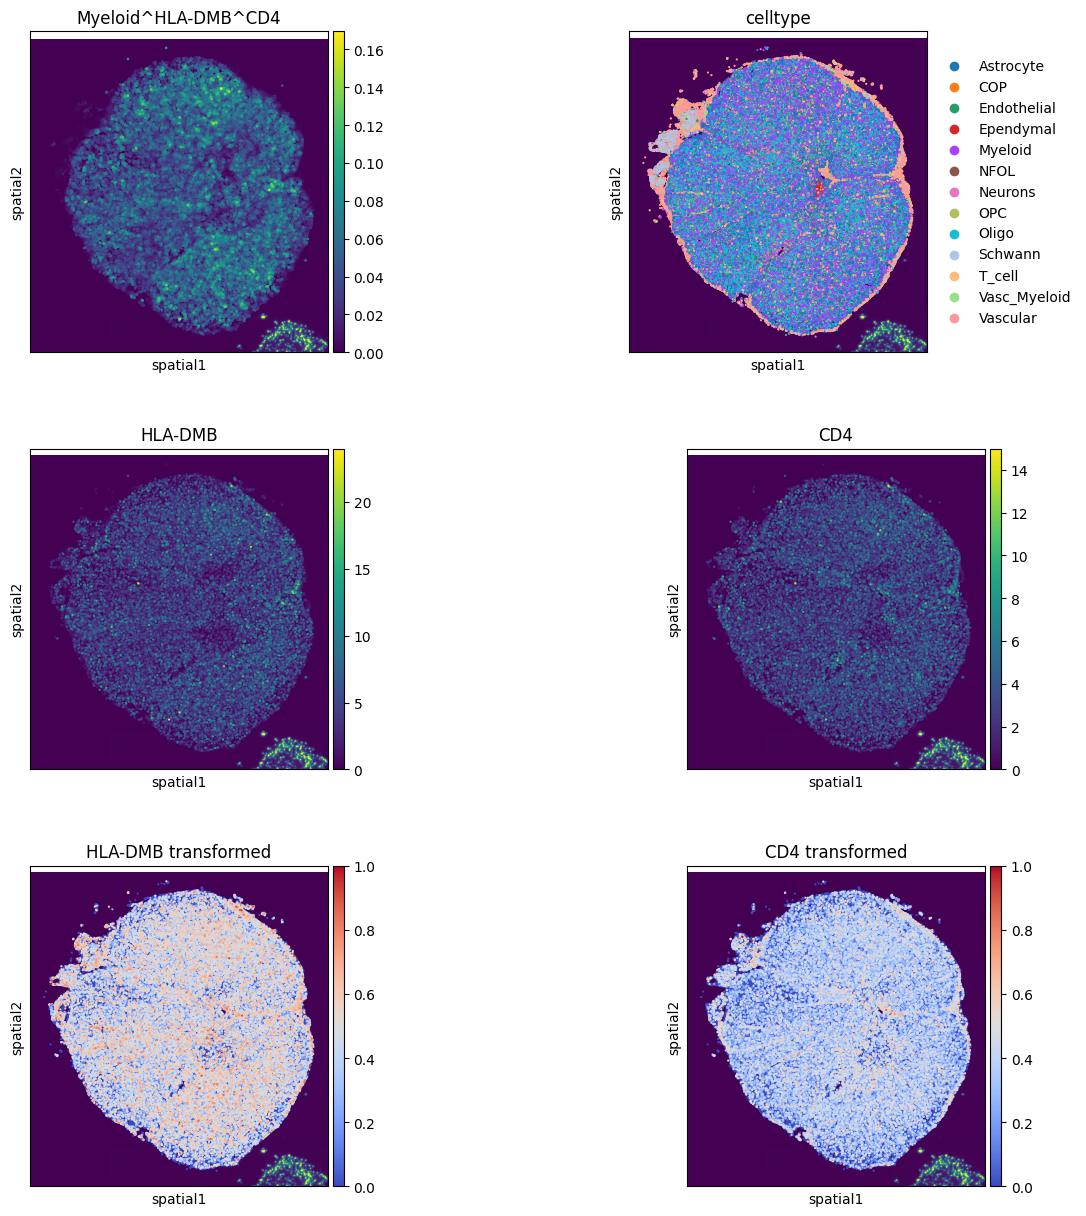

In [32]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
axes = axes.flatten()

# Define your keys
key = 'Myeloid^HLA-DMB^CD4' #NOTE @Moeed, sanity check interaction for Macrophage infiltration
xy_sep = '^'
groupby = 'celltype'
keys = key.split(xy_sep)

if len(keys) < 2:
    raise ValueError("The 'key' variable should contain at least two elements separated by '&'.")

ligand = keys[1]
receptor = keys[2]

adata.obs['receptor'] = (adata[:, receptor].X > 0).toarray().flatten()

sample = "Active-C_2013-019"

sc.pl.spatial(lrdata, color=[key], spot_size=100, ax=axes[0],show=False, library_id=sample)
axes[0].set_title(f"{key}")
sc.pl.spatial(adata, color=[groupby], spot_size=80, ax=axes[1],show=False, library_id=sample)
axes[1].set_title(f"{groupby}")
sc.pl.spatial(adata, color=[ligand], spot_size=80, ax=axes[2], show=False, library_id=sample)
axes[2].set_title(f"{ligand}")
sc.pl.spatial(adata, color=[receptor], spot_size=80, ax=axes[3], show=False, library_id=sample)
axes[3].set_title(f"{receptor}")
sc.pl.spatial(adata, color=[ligand], spot_size=80, ax=axes[4], show=False, layer='transformed', cmap='coolwarm', library_id=sample)
axes[4].set_title(f"{ligand} transformed")
sc.pl.spatial(adata, color=[receptor], spot_size=80, ax=axes[5], show=False, layer='transformed', cmap='coolwarm', library_id=sample)
axes[5].set_title(f"{receptor} transformed")
plt.show()